In [1]:
from torchvision import datasets
import torch

data_folder = "/content/"
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.59MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 63.1MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.8MB/s]


In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [11]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"


Dropout 0.25

In [4]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

In [5]:
from torch.optim import SGD, Adam


def get_model():
    model = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1000, 10),
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [6]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [7]:
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [8]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [9]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [12]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [13]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


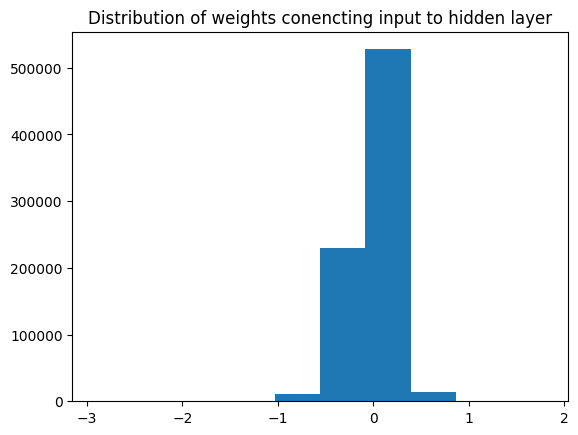

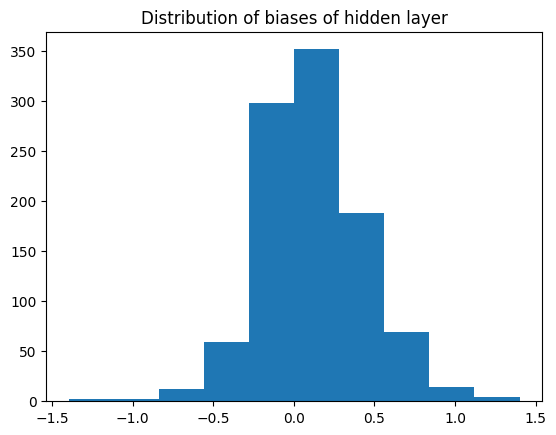

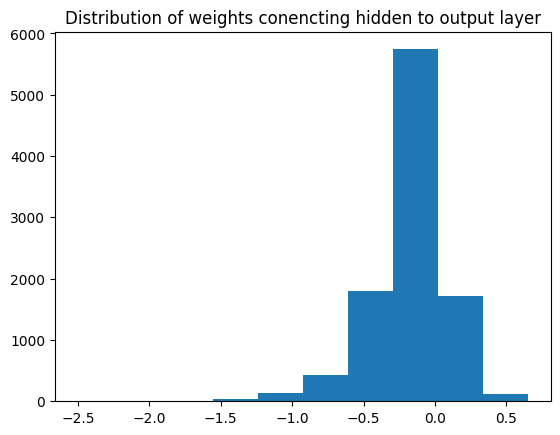

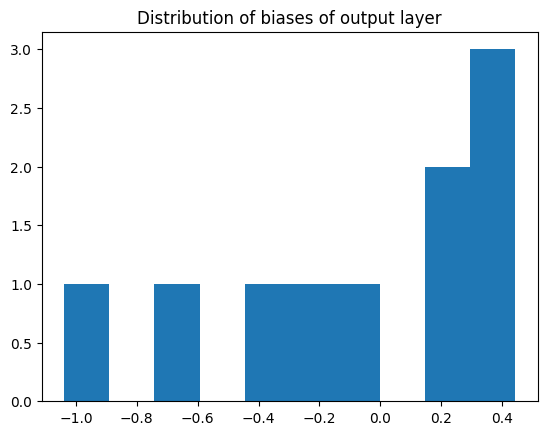

In [14]:
for ix, par in enumerate(model.parameters()):
    if ix == 0:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of weights conencting input to hidden layer")
        plt.show()
    elif ix == 1:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of biases of hidden layer")
        plt.show()
    elif ix == 2:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of weights conencting hidden to output layer")
        plt.show()
    elif ix == 3:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of biases of output layer")
        plt.show()


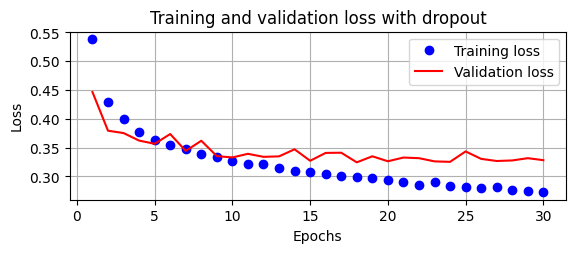

/tmp/ipython-input-2993417705.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


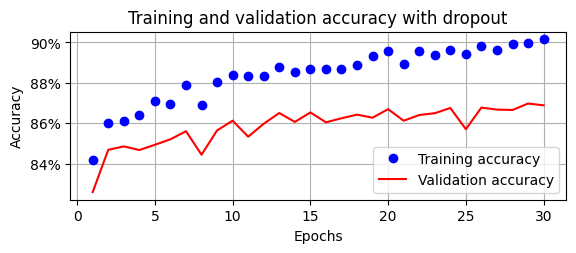

In [15]:
epochs = np.arange(30) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, "bo", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation loss with dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("off")
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy with dropout")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

no dropout

In [16]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

In [17]:
from torch.optim import SGD, Adam


def get_model():
    model = nn.Sequential(nn.Linear(28 * 28, 1000), nn.ReLU(), nn.Linear(1000, 10)).to(
        device
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [18]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [19]:
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [20]:
trn_dl, val_dl = get_data()
model2, loss_fn, optimizer = get_model()

In [21]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model2, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model2)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model2)
        validation_loss = val_loss(x, y, model2)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


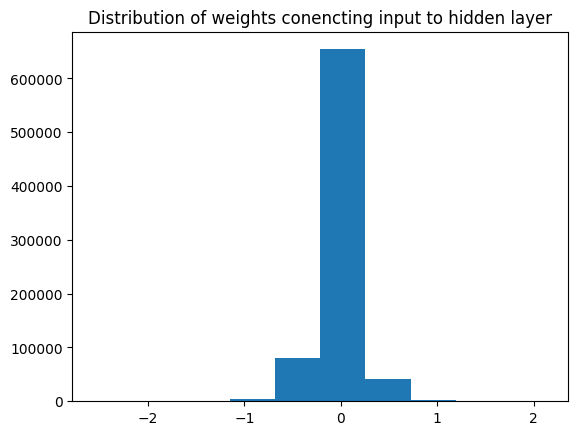

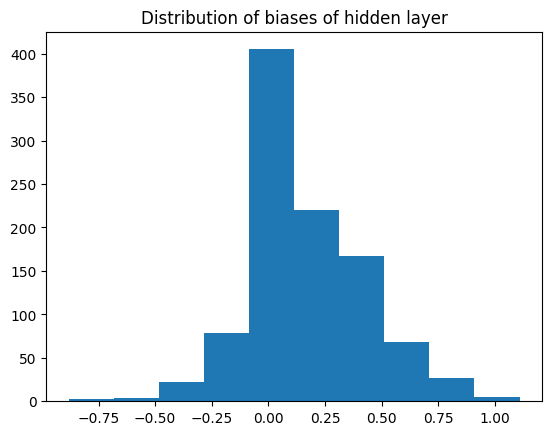

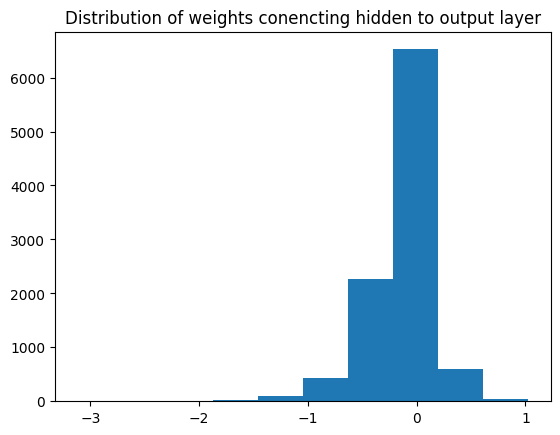

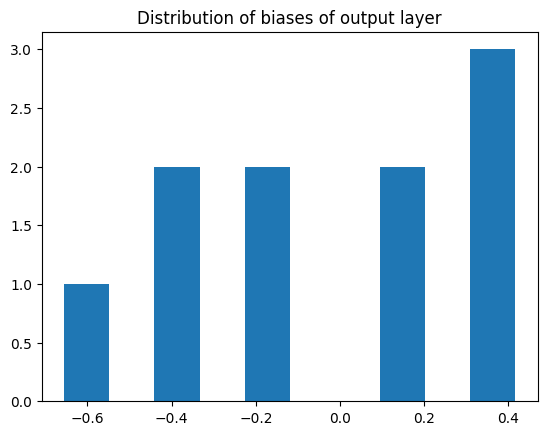

In [22]:
for ix, par in enumerate(model2.parameters()):
    if ix == 0:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of weights conencting input to hidden layer")
        plt.show()
    elif ix == 1:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of biases of hidden layer")
        plt.show()
    elif ix == 2:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of weights conencting hidden to output layer")
        plt.show()
    elif ix == 3:
        plt.hist(par.cpu().detach().numpy().flatten())
        # plt.xlim(-2,2)
        plt.title("Distribution of biases of output layer")
        plt.show()

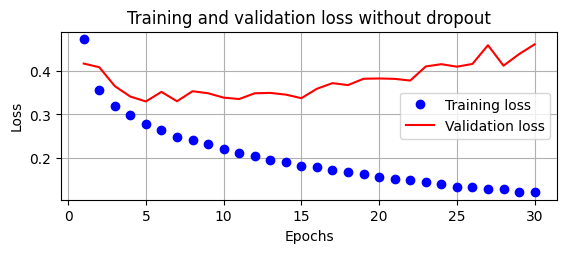

/tmp/ipython-input-868074537.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


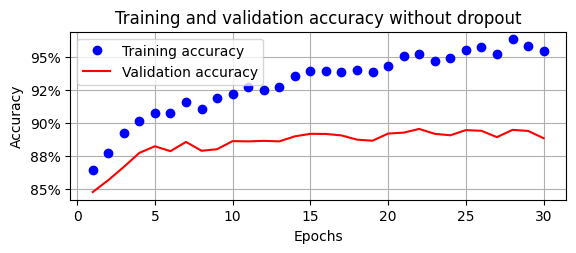

In [23]:
plt.subplot(211)
plt.plot(epochs, train_losses, "bo", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation loss without dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("off")
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy without dropout")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

weight distribution per layer; without dropout

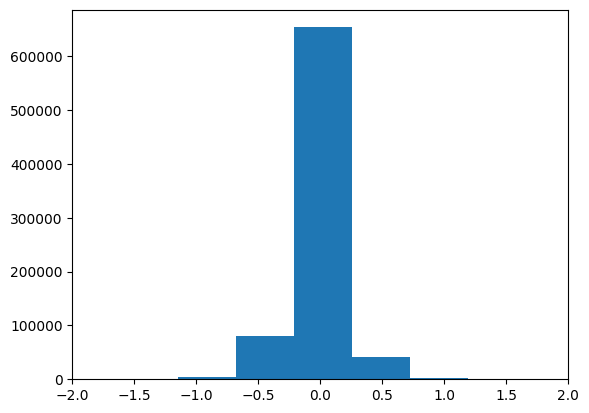

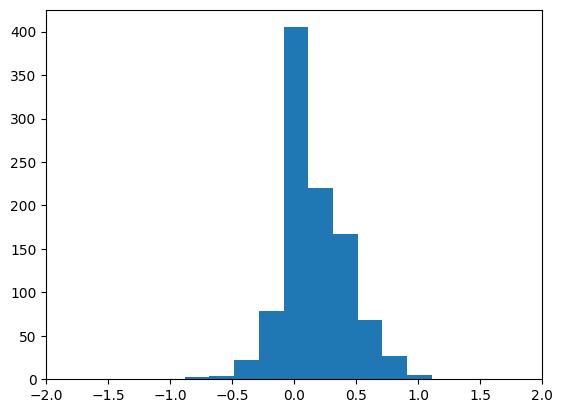

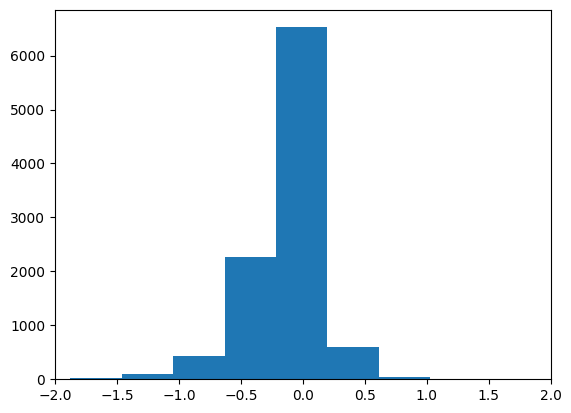

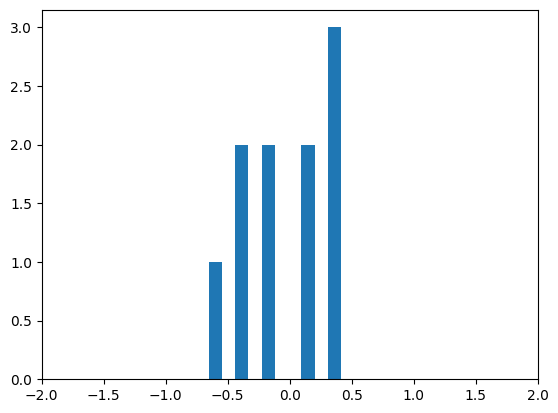

In [24]:
for par in model2.parameters():
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.xlim(-2, 2)
    plt.show()


weight distribution per layer; with dropout

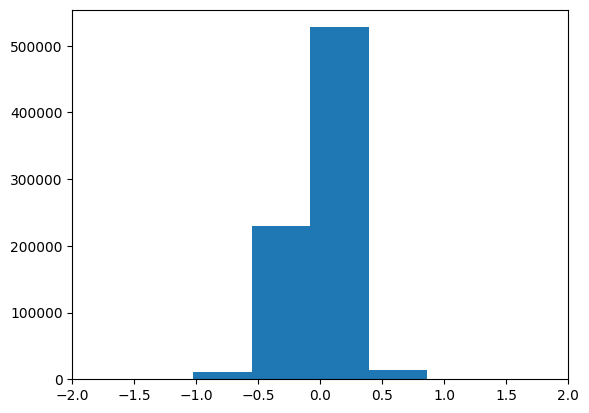

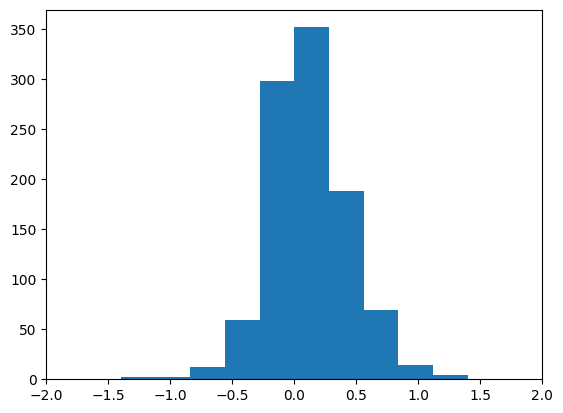

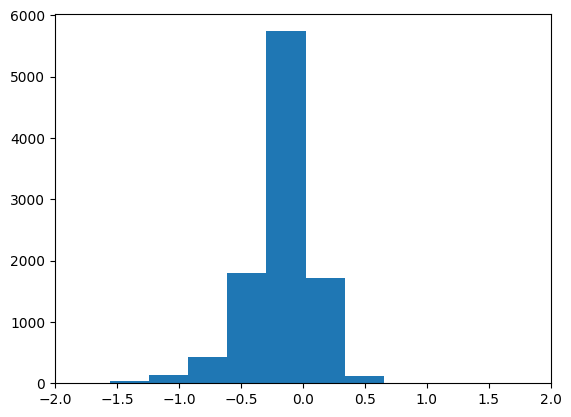

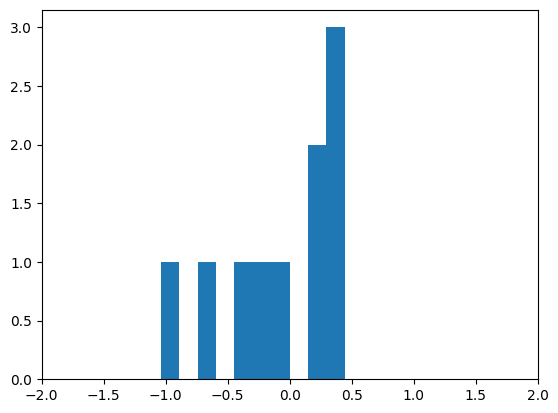

In [25]:

for par in model.parameters():
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.xlim(-2, 2)
    plt.show()